📈 R²: 0.074
📉 RMSE: 2.783
📉 MAE: 1.907


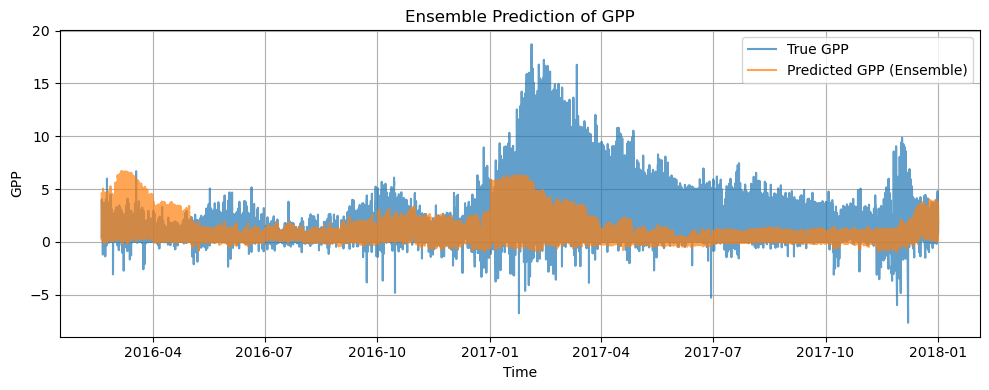

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# === Step 1：加载 NetCDF 文件 ===
flux_path = "AU-ASM_2011-2017_OzFlux_Flux.nc"
forcing_path = "AU-ASM_2011-2017_OzFlux_Met.nc"

ds_flux = xr.open_dataset(flux_path)
ds_forcing = xr.open_dataset(forcing_path)

# 对齐时间维度
common_time = np.intersect1d(ds_flux['time'].values, ds_forcing['time'].values)
ds_merged = xr.merge([ds_flux.sel(time=common_time), ds_forcing.sel(time=common_time)])
df = ds_merged.to_dataframe().reset_index()
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# === Step 2：筛选白天时间段（06:00–18:00）===
df = df.between_time("06:00", "18:00")

# === Step 3：添加特征 ===
df['hour'] = df.index.hour
df['month'] = df.index.month
df['doy'] = df.index.dayofyear

# 滑动平均（3小时 = 6 个 30min）
df['SWdown_3h_mean'] = df['SWdown'].rolling(6).mean()
df['Tair_3h_mean'] = df['Tair'].rolling(6).mean()

# 滞后变量
df['SWdown_lag3'] = df['SWdown'].shift(6)
df['Tair_lag6'] = df['Tair'].shift(12)

# 组合变量
df['SW_LAI'] = df['SWdown'] * df['LAI']
df['RH_Tair'] = df['RH'] * df['Tair']
df['SWdown_lag1'] = df['SWdown'].shift(2)
df['Tair_lag1'] = df['Tair'].shift(2)

# 删除缺失值
df = df.dropna()

# === Step 4：准备建模数据 ===
features = ['SWdown', 'LWdown', 'Tair', 'Qair', 'RH', 'Psurf', 'Wind',
            'CO2air', 'VPD', 'LAI', 'Ustar', 'hour', 'month', 'doy',
            'SWdown_3h_mean', 'Tair_3h_mean', 'SWdown_lag3', 'Tair_lag6',
            'SW_LAI', 'RH_Tair', 'SWdown_lag1', 'Tair_lag1']
target = 'GPP'

X = df[features].values
y = df[target].values

# 时间顺序划分训练集与测试集（70%/30%）
split_index = int(len(df) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
time_test = df.index[split_index:]

# === Step 5：训练模型（XGBoost + Random Forest）===
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3,
                         subsample=0.8, colsample_bytree=1.0,
                         reg_alpha=0.1, reg_lambda=1.0,
                         objective='reg:squarederror', random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)

xgb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# === Step 6：融合预测与评估 ===
y_pred_xgb = xgb_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_avg = (y_pred_xgb + y_pred_rf) / 2

r2 = r2_score(y_test, y_pred_avg)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_avg))
mae = mean_absolute_error(y_test, y_pred_avg)

print(f"📈 R²: {r2:.3f}")
print(f"📉 RMSE: {rmse:.3f}")
print(f"📉 MAE: {mae:.3f}")

# === Step 7：可视化预测效果 ===
plt.figure(figsize=(10, 4))
plt.plot(time_test, y_test, label='True GPP', alpha=0.7)
plt.plot(time_test, y_pred_avg, label='Predicted GPP (Ensemble)', alpha=0.7)
plt.legend()
plt.title("Ensemble Prediction of GPP")
plt.xlabel("Time")
plt.ylabel("GPP")
plt.tight_layout()
plt.grid()
plt.show()


📈 R²: 0.068
📉 RMSE: 2.792
📉 MAE: 1.919


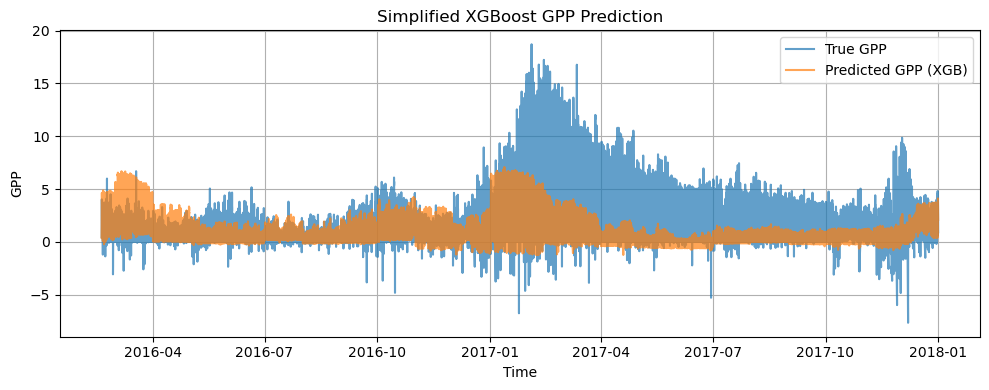

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# === Step 1：加载 NetCDF 数据 ===
flux_path = "AU-ASM_2011-2017_OzFlux_Flux.nc"
forcing_path = "AU-ASM_2011-2017_OzFlux_Met.nc"

ds_flux = xr.open_dataset(flux_path)
ds_forcing = xr.open_dataset(forcing_path)

common_time = np.intersect1d(ds_flux['time'].values, ds_forcing['time'].values)
ds_merged = xr.merge([ds_flux.sel(time=common_time), ds_forcing.sel(time=common_time)])
df = ds_merged.to_dataframe().reset_index()
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# === Step 2：筛选白天时间段（06:00–18:00）===
df = df.between_time("06:00", "18:00")

# === Step 3：构造增强特征（精选）===
df['hour'] = df.index.hour
df['month'] = df.index.month
df['doy'] = df.index.dayofyear

df['SW_LAI'] = df['SWdown'] * df['LAI']
df['RH_Tair'] = df['RH'] * df['Tair']
df['SWdown_lag1'] = df['SWdown'].shift(2)
df['Tair_lag1'] = df['Tair'].shift(2)

df = df.dropna()

# === Step 4：准备特征与目标 ===
features = ['SWdown', 'LWdown', 'Tair', 'Qair', 'RH', 'Psurf',
            'Wind', 'CO2air', 'VPD', 'LAI', 'Ustar',
            'hour', 'month', 'doy',
            'SW_LAI', 'RH_Tair', 'SWdown_lag1', 'Tair_lag1']
target = 'GPP'

X = df[features].values
y = df[target].values

# === Step 5：时间顺序划分训练/测试集 ===
split_index = int(len(df) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
time_test = df.index[split_index:]

# === Step 6：XGBoost 模型训练与预测（使用你之前的最佳参数）===
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=1.0,
    reg_alpha=0.1,
    reg_lambda=1.0,
    objective='reg:squarederror',
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# === Step 7：评估结果 ===
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"📈 R²: {r2:.3f}")
print(f"📉 RMSE: {rmse:.3f}")
print(f"📉 MAE: {mae:.3f}")

# === 可视化预测效果 ===
plt.figure(figsize=(10, 4))
plt.plot(time_test, y_test, label='True GPP', alpha=0.7)
plt.plot(time_test, y_pred, label='Predicted GPP (XGB)', alpha=0.7)
plt.legend()
plt.title("Simplified XGBoost GPP Prediction")
plt.xlabel("Time")
plt.ylabel("GPP")
plt.tight_layout()
plt.grid()
plt.show()


Fitting 3 folds for each of 30 candidates, totalling 90 fits
✅ Best Parameters: {'subsample': 1.0, 'reg_lambda': 2.0, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
📈 Best CV R²: 0.4817451934455643
📊 Test R²: 0.48744077524943485
📉 RMSE: 2.0153509506865266
📉 MAE: 1.4841708604645942


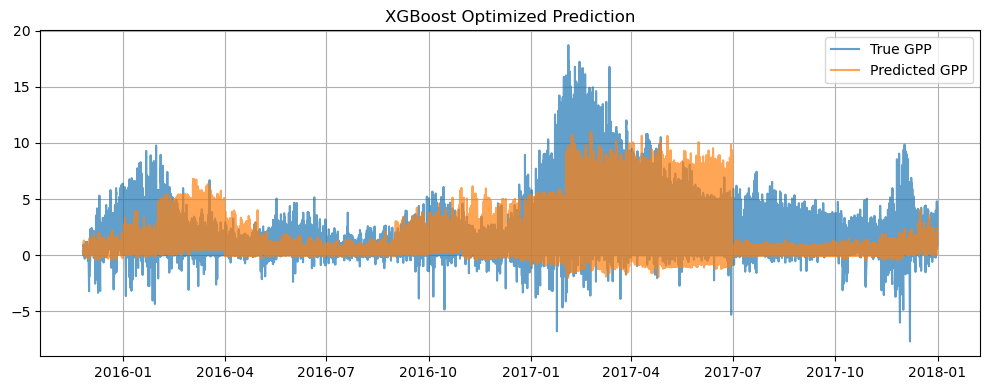

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# === 加载优化数据 ===
df = pd.read_csv("AU_ASM_optimized_data.csv", parse_dates=['time'], index_col='time')
features = ['SWdown', 'LWdown', 'Tair', 'Qair', 'RH', 'Psurf',
            'Wind', 'CO2air', 'VPD', 'LAI', 'Ustar',
            'SW_LAI', 'RH_Tair', 'SWdown_lag1', 'Tair_lag1']
target = 'GPP'

X = df[features].values
y = df[target].values

# === 时间顺序划分训练集 / 测试集 ===
split_index = int(len(df) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
time_test = df.index[split_index:]

# === 定义搜索空间和交叉验证器 ===
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.5, 1.0, 2.0]
}

tscv = TimeSeriesSplit(n_splits=3)

search = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=param_dist,
    n_iter=30,
    scoring='r2',
    cv=tscv,
    verbose=2,
    n_jobs=-1
)

# === 启动搜索 ===
search.fit(X_train, y_train)

# === 输出最佳结果 ===
print("✅ Best Parameters:", search.best_params_)
print("📈 Best CV R²:", search.best_score_)

# === 用最佳模型预测测试集 ===
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

print("📊 Test R²:", r2_score(y_test, y_pred))
print("📉 RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("📉 MAE:", mean_absolute_error(y_test, y_pred))

# === 可视化预测 vs 实际 ===
plt.figure(figsize=(10, 4))
plt.plot(time_test, y_test, label='True GPP', alpha=0.7)
plt.plot(time_test, y_pred, label='Predicted GPP', alpha=0.7)
plt.legend()
plt.title("XGBoost Optimized Prediction")
plt.grid()
plt.tight_layout()
plt.show()



Fitting 3 folds for each of 30 candidates, totalling 90 fits
✅ Best Parameters: {'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
📈 Best CV R²: 0.4752912907099652
📊 Test R²: 0.5086850689443926
📉 RMSE: 1.9731433528679516
📉 MAE: 1.4330655074875691


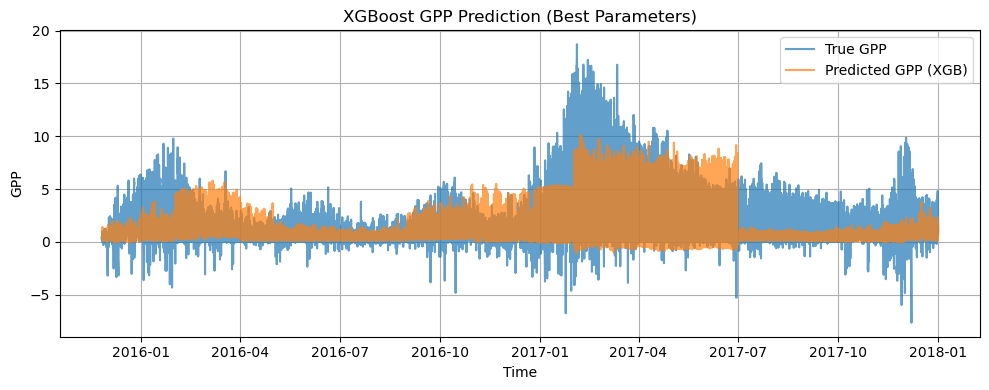

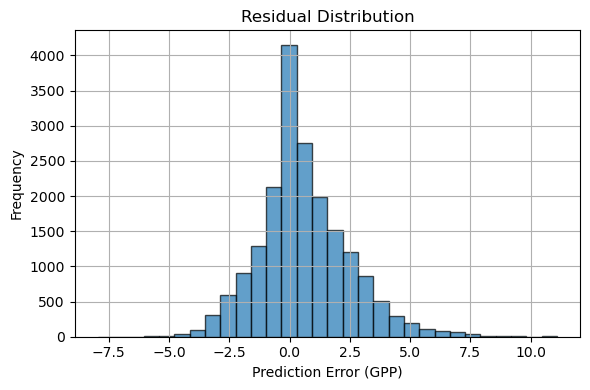

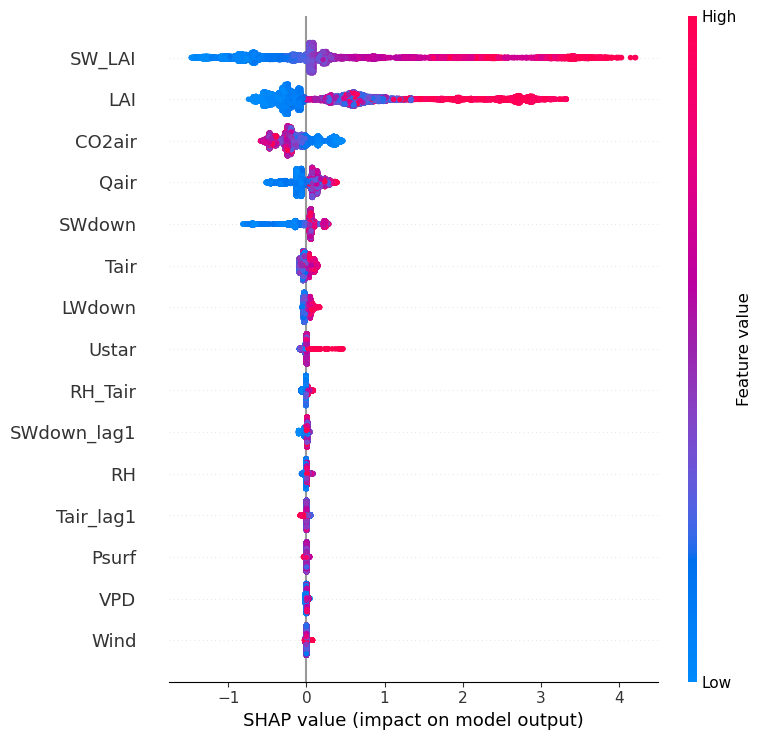

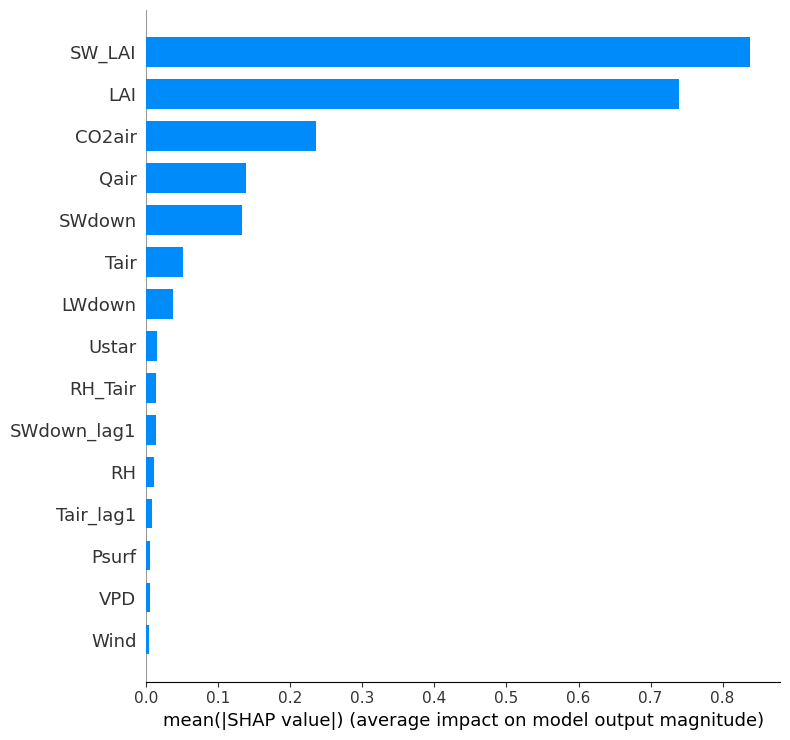

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import shap

# === 加载优化数据 ===
df = pd.read_csv("AU_ASM_optimized_data.csv", parse_dates=['time'], index_col='time')
features = ['SWdown', 'LWdown', 'Tair', 'Qair', 'RH', 'Psurf',
            'Wind', 'CO2air', 'VPD', 'LAI', 'Ustar',
            'SW_LAI', 'RH_Tair', 'SWdown_lag1', 'Tair_lag1']
target = 'GPP'

X = df[features].values
y = df[target].values

# === 时间顺序划分训练集 / 测试集 ===
split_index = int(len(df) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
time_test = df.index[split_index:]

# === 定义搜索空间和交叉验证器 ===
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.5, 1.0, 2.0]
}
tscv = TimeSeriesSplit(n_splits=3)

search = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=param_dist,
    n_iter=30,
    scoring='r2',
    cv=tscv,
    verbose=2,
    n_jobs=-1
)

# === 启动搜索 ===
search.fit(X_train, y_train)
best_model = search.best_estimator_

# === 用最佳模型预测测试集 ===
y_pred = best_model.predict(X_test)

print("✅ Best Parameters:", search.best_params_)
print("📈 Best CV R²:", search.best_score_)
print("📊 Test R²:", r2_score(y_test, y_pred))
print("📉 RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("📉 MAE:", mean_absolute_error(y_test, y_pred))

# === 图1：预测 vs 实际 ===
plt.figure(figsize=(10, 4))
plt.plot(time_test, y_test, label='True GPP', alpha=0.7)
plt.plot(time_test, y_pred, label='Predicted GPP (XGB)', alpha=0.7)
plt.legend()
plt.title("XGBoost GPP Prediction (Best Parameters)")
plt.xlabel("Time")
plt.ylabel("GPP")
plt.grid()
plt.tight_layout()
plt.show()

# === 图2：残差分布 ===
plt.figure(figsize=(6, 4))
residuals = y_test - y_pred
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title("Residual Distribution")
plt.xlabel("Prediction Error (GPP)")
plt.ylabel("Frequency")
plt.grid()
plt.tight_layout()
plt.show()

# === 输出预测结果 CSV ===
df_result = pd.DataFrame({
    'time': time_test,
    'True_GPP': y_test,
    'Predicted_GPP': y_pred
})
df_result.to_csv("GPP_prediction_xgb_best.csv", index=False)

# === SHAP 可解释性分析 ===
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

# 图3：SHAP Summary（按每条样本）
shap.summary_plot(shap_values, X_test, feature_names=features)

# 图4：SHAP Bar（平均重要性）
shap.summary_plot(shap_values, X_test, feature_names=features, plot_type="bar")
